In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [6]:
import numpy as np
images = np.load("/content/drive/MyDrive/brain_tumor_dataset/images.npy", allow_pickle=True)
masks = np.load("/content/drive/MyDrive/brain_tumor_dataset/masks.npy", allow_pickle=True)
labels = np.load("/content/drive/MyDrive/brain_tumor_dataset/labels.npy")
integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

print(f"images:{images.shape}, \
masks:{masks.shape}, \
labels:{labels.shape}")

images:(3064,), masks:(3064,), labels:(3064,)


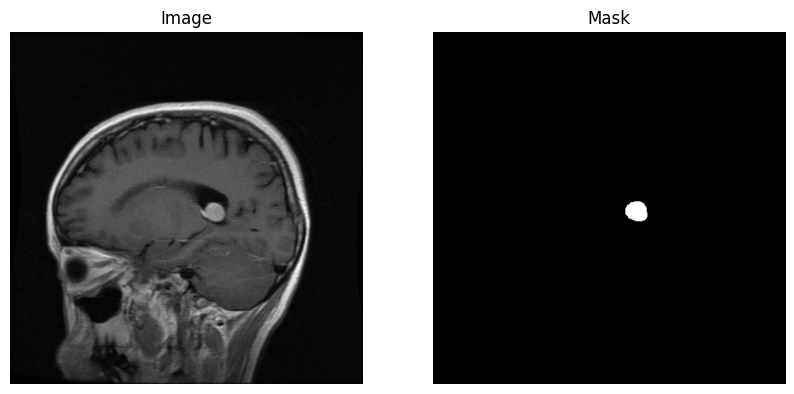

In [7]:
import matplotlib.pyplot as plt
def display_sample(data, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(data['images'][index], cmap='gray')
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(data['masks'][index], cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.show()

# Display a sample to verify
display_sample({'images': images, 'masks': masks}, index=0)

In [8]:
from skimage.transform import resize
def preprocess_images(images, masks, target_shape=(256, 256)):
    processed_images = np.array([resize(img, target_shape, preserve_range=True) for img in images])
    processed_masks = np.array([resize(mask, target_shape, mode='constant', anti_aliasing=False) for mask in masks])

    # Normalize images
    processed_images = processed_images.astype('float32') / 255.0

    return processed_images, processed_masks

images_processed, masks_processed = preprocess_images(images, masks)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images_processed, masks_processed, test_size=0.2, random_state=42)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, UpSampling2D, concatenate

def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def down_block(inputs, filters, pool_size=(2, 2), dropout=False):
    x = conv_block(inputs, filters)
    if dropout:
        x = Dropout(0.5)(x)
    pool = MaxPooling2D(pool_size)(x)
    return x, pool

def up_block(inputs, skip, filters, up_size=(2, 2)):
    x = UpSampling2D(up_size)(inputs)
    x = concatenate([x, skip], axis=3)
    x = conv_block(x, filters)
    return x

def vnet_model(input_size=(256, 256, 1), filters=16, num_classes=1):
    inputs = Input(input_size)

    # Encoder
    e1, p1 = down_block(inputs, filters)
    e2, p2 = down_block(p1, filters * 2)
    e3, p3 = down_block(p2, filters * 4)
    e4, p4 = down_block(p3, filters * 8)

    # Bottleneck
    b = conv_block(p4, filters * 16)

    # Decoder
    d4 = up_block(b, e4, filters * 8)
    d3 = up_block(d4, e3, filters * 4)
    d2 = up_block(d3, e2, filters * 2)
    d1 = up_block(d2, e1, filters)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(d1)
    model = Model(inputs, outputs)
    return model

model = vnet_model()
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 256, 256, 16)         160       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d_4[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normalization[0]

In [18]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=20)



Epoch 1/20
307/307 [==============================] - 51s 116ms/step - loss: 0.2606 - accuracy: 0.9692 - val_loss: 0.1513 - val_accuracy: 0.9831
Epoch 2/20
307/307 [==============================] - 29s 95ms/step - loss: 0.0984 - accuracy: 0.9831 - val_loss: 0.0777 - val_accuracy: 0.9831
Epoch 3/20
307/307 [==============================] - 29s 96ms/step - loss: 0.0656 - accuracy: 0.9835 - val_loss: 0.0681 - val_accuracy: 0.9836
Epoch 4/20
307/307 [==============================] - 30s 97ms/step - loss: 0.0498 - accuracy: 0.9855 - val_loss: 0.0488 - val_accuracy: 0.9845
Epoch 5/20
307/307 [==============================] - 30s 99ms/step - loss: 0.0391 - accuracy: 0.9874 - val_loss: 0.0478 - val_accuracy: 0.9847
Epoch 6/20
307/307 [==============================] - 29s 96ms/step - loss: 0.0324 - accuracy: 0.9889 - val_loss: 0.0320 - val_accuracy: 0.9894
Epoch 7/20
307/307 [==============================] - 31s 101ms/step - loss: 0.0278 - accuracy: 0.9904 - val_loss: 0.0765 - val_accurac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


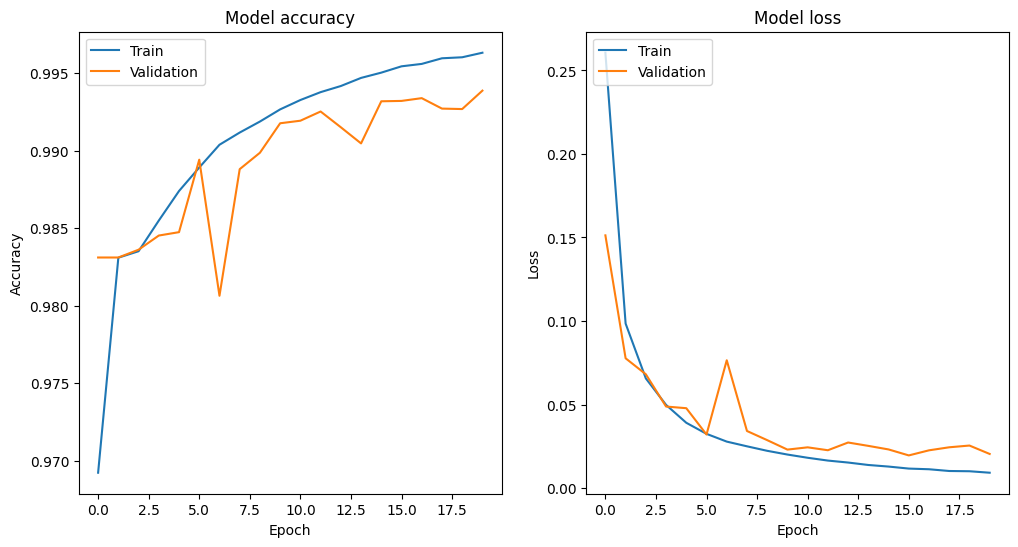

In [19]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
if 'dice_coefficient' in history.history:
    plt.figure(figsize=(6, 5))
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('Model Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [20]:
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation accuracy:", accuracy)
predictions = model.predict(X_val)

20/20 [==============================] - 6s 92ms/step - loss: 0.0204 - accuracy: 0.9939
Validation accuracy: 0.9938634037971497
20/20 [==============================] - 2s 93ms/step


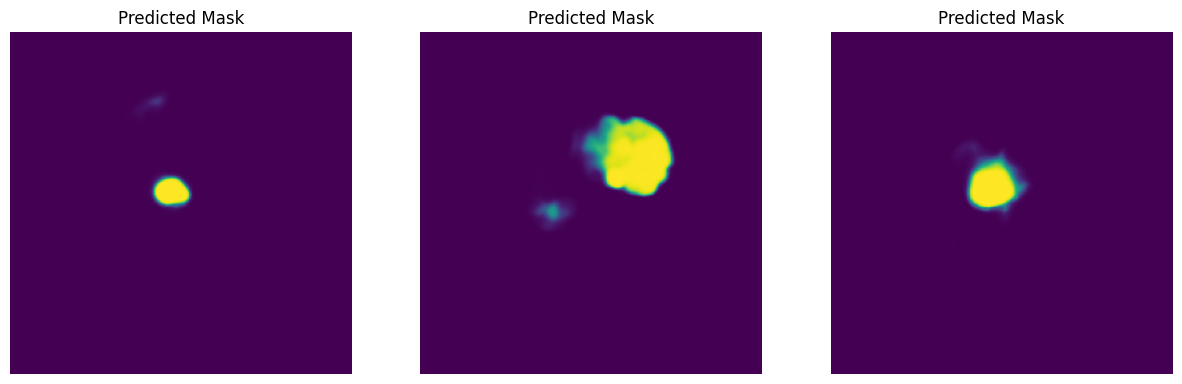

In [21]:
def display_comparison(indices):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)
        plt.imshow(np.squeeze(predictions[idx]), cmap='viridis')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
display_comparison([0, 1, 2])

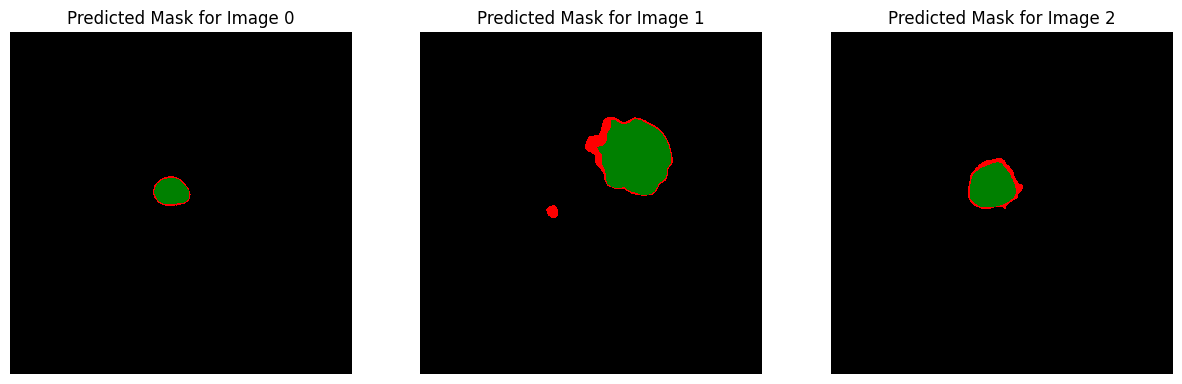

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
colors = ['black', 'red', 'green']  # Add more colors if there are more classes
cmap = ListedColormap(colors)

def display_comparison(predictions, indices):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)
        plt.imshow(np.squeeze(predictions[idx]), cmap=cmap)
        plt.title(f'Predicted Mask for Image {idx}')
        plt.axis('off')
    plt.show()
display_comparison(predictions, [0, 1, 2])


In [23]:
predicted_masks = model.predict(X_val)

20/20 [==============================] - 2s 94ms/step


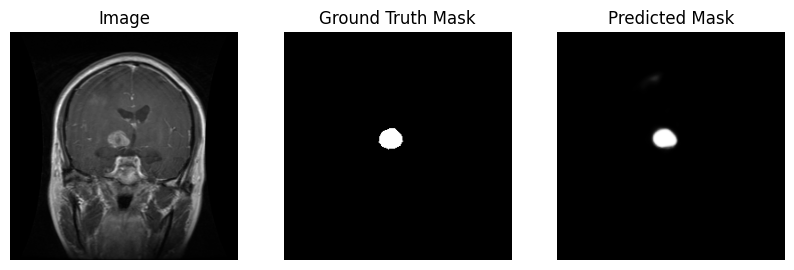

In [24]:
def display_predicted_masks(images, masks, predicted_masks, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[index], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[index].reshape(256, 256), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Display a sample of predicted masks on original images
display_predicted_masks(X_val, y_val, predicted_masks, index=0)

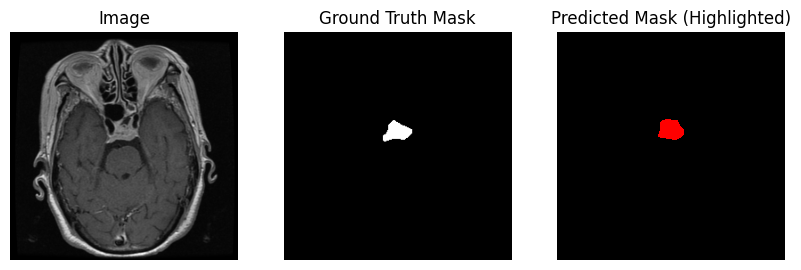

In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'red'])

def display_predicted_masks(images, masks, predicted_masks, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[index], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[index].reshape(256, 256), cmap=cmap)
    plt.title('Predicted Mask (Highlighted)')
    plt.axis('off')

    plt.show()
display_predicted_masks(X_val, y_val, predicted_masks, index=150)
